In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Residual Neural Networks applied to classification 

We will again use MNIST data set to train, validation, and test but this time using ResNN. As described in lecture, we are going to formulate a skip connection in order to improve gradient flow. 

Using the CNN developed in HW 8, adapt your architecture to the one shown in the figure below (architecture with two layers each composed of one convolution and one pooling layer). Use ReLU as your activation function. Use conv/pooling layers that with kernel, stride, and padding size that lead to output size of 12x5x5 before flattening. Flatten the resulting feature maps and use two fully connected layers of output size 300,10. Add an additive skip connection from flattened later to the second fully connected layer. Again use the ADAM optimizer with learning rate of 1e-3, batchsize of 128, and 30 epochs. Split the MNISt training set into 2/3 for training and 1/3 for validation, you don't need to do KFols this time. use batch normalization of data, and choose some regularization techniques and converge your training to where the loss function is minimal. 

In [5]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [6]:
data = np.array(pd.read_pickle("/content/gdrive/MyDrive/Colab Notebooks/CHEM277B/Homework7/mnist.pkl"), dtype=object)
data[0][0] = data[0][0]/255 
data[1][0] = data[1][0]/255

data[0][0].shape

(60000, 32, 32)

In [7]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

from torch import nn 
import torch
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        inputs = self.input_transform(inputs)
        val_inputs = self.input_transform(val_inputs)
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_lambda = 0.00001
                    l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())
                    loss += l2_lambda * l2_norm
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().item() * batch_importance
                pred = torch.argmax(batch_predictions, axis=-1)
                acc = torch.sum(pred == batch_output).item() / len(batch_predictions)
                epoch_acc += acc * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        inputs = self.input_transform(inputs)
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                ### Compute prediction and loss###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            pred = torch.argmax(batch_predictions, axis=-1)  
            batch_acc = torch.sum(pred == batch_output) / len(batch_predictions)
            losses += loss.detach().item() * batch_importance
            acc += batch_acc.detach().item() * batch_importance
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc


kf = KFold(n_splits=3, shuffle=True, random_state=42)
training_data = data[0][0]
training_labels = data[0][1]

training_set = []
validation_set = []
training_label = []
validation_label = []

# The data folder you are given is already organized into training, and a test set. Therefore, to create a validation set, 
# divide the original training data into 3-fold groups of training and validation data.
for train_index, val_index in kf.split(training_data):
    X_train, X_val = training_data[train_index], training_data[val_index]
    y_train, y_val = training_labels[train_index], training_labels[val_index]
    training_set.append(X_train)
    validation_set.append(X_val)
    training_label.append(y_train)
    validation_label.append(y_val)

### a) Run the model with and without batch normalization. Which give you better test accuracy?

In [8]:
#This model does not have batch normalization or skip connection 
from torch import nn
import torch
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1,6,kernel_size=3,padding=1), 
                                  nn.Conv2d(6,12,kernel_size=3,padding=1)]) 
        self.fc = nn.ModuleList([nn.Linear(300,300),nn.Linear(300,10)]) 
        self.pool1 = nn.MaxPool2d(kernel_size=2) 
        self.pool2 = nn.MaxPool2d(kernel_size=3) 
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.conv[0](x)
        x = self.pool1(self.activation(x))
        x = self.conv[1](x)
        x = self.pool2(self.activation(x))
        x = x.flatten(start_dim=1)
        x = self.fc[0](x)
        x = self.activation(x)
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

  3%|▎         | 1/30 [00:13<06:31, 13.50s/it]

Epoch 1/30 - Loss: 1.778 - Acc: 0.714
              Val_loss: 1.612 - Val_acc: 0.856


 37%|███▋      | 11/30 [02:24<04:15, 13.44s/it]

Epoch 11/30 - Loss: 1.480 - Acc: 0.982
              Val_loss: 1.483 - Val_acc: 0.979


 70%|███████   | 21/30 [04:33<01:55, 12.88s/it]

Epoch 21/30 - Loss: 1.471 - Acc: 0.991
              Val_loss: 1.478 - Val_acc: 0.983


func:'train'  took: 394.0779 sec
Training accuracy:  0.9937
Validation accuracy:  0.9849499999999982


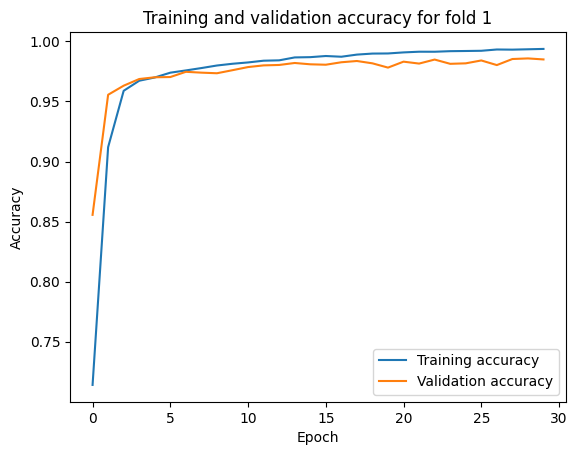

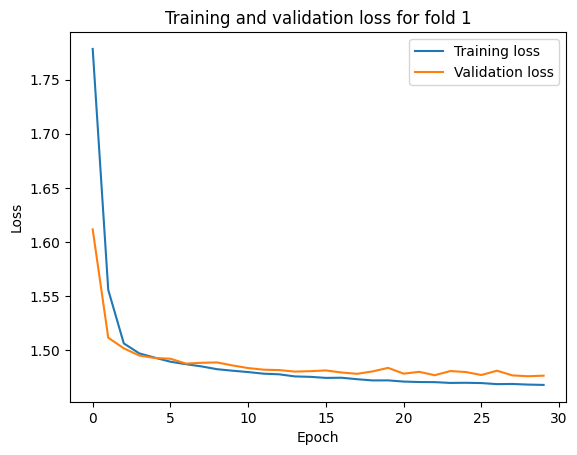

  3%|▎         | 1/30 [00:12<06:14, 12.91s/it]

Epoch 1/30 - Loss: 1.724 - Acc: 0.756
              Val_loss: 1.549 - Val_acc: 0.920


 37%|███▋      | 11/30 [02:28<04:21, 13.74s/it]

Epoch 11/30 - Loss: 1.483 - Acc: 0.980
              Val_loss: 1.488 - Val_acc: 0.974


 70%|███████   | 21/30 [04:38<01:58, 13.20s/it]

Epoch 21/30 - Loss: 1.474 - Acc: 0.988
              Val_loss: 1.479 - Val_acc: 0.983


func:'train'  took: 397.5016 sec
Training accuracy:  0.992075
Validation accuracy:  0.983549999999998


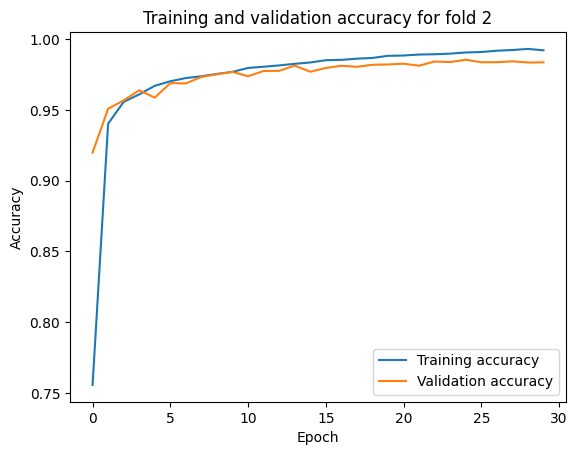

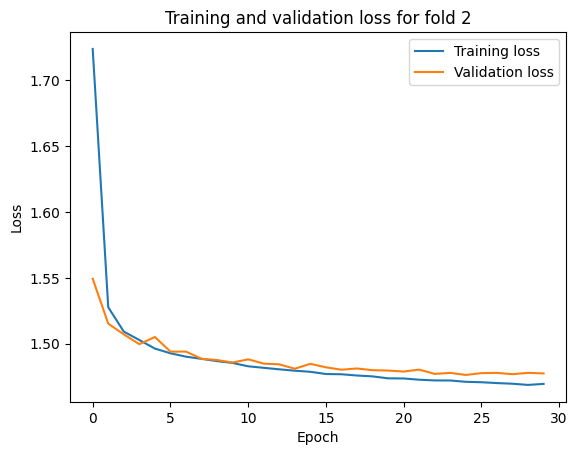

  3%|▎         | 1/30 [00:14<07:05, 14.67s/it]

Epoch 1/30 - Loss: 1.766 - Acc: 0.713
              Val_loss: 1.630 - Val_acc: 0.836


 37%|███▋      | 11/30 [02:22<03:59, 12.58s/it]

Epoch 11/30 - Loss: 1.480 - Acc: 0.982
              Val_loss: 1.484 - Val_acc: 0.978


 70%|███████   | 21/30 [04:20<01:44, 11.64s/it]

Epoch 21/30 - Loss: 1.472 - Acc: 0.990
              Val_loss: 1.481 - Val_acc: 0.980


func:'train'  took: 375.1148 sec
Training accuracy:  0.9934249999999996
Validation accuracy:  0.9829999999999979


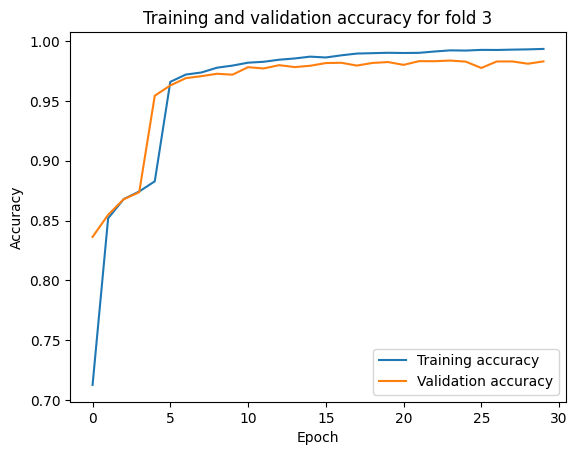

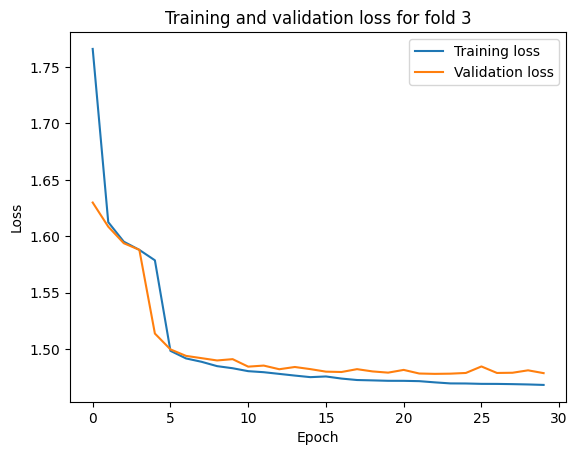

Summary: 
Training accuracy:  0.9930666666666665
Validation accuracy:  0.9838333333333313


In [ ]:
# The training and validation accuracy of the model
# The training and validation accuracy of the model
run_info_list = []
for i in range(3):
    model = ResNet()
    trainer = Trainer(model, optimizer_type='adam', learning_rate=1e-3, batch_size=128, epoch=30, input_transform = lambda x:x)
    run_info = trainer.train(training_set[i], training_label[i], validation_set[i], validation_label[i])
    run_info_list.append(run_info)
    print("Training accuracy: ", run_info["accuracies"][-1])
    print("Validation accuracy: ", run_info["val_accuracies"][-1])

    # Plot the training and validation accuracy for fold 1 
    plt.plot(run_info["accuracies"], label="Training accuracy")
    plt.plot(run_info["val_accuracies"], label="Validation accuracy")
    plt.title("Training and validation accuracy for fold %d" % (i+1))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Plot the training and validation loss for fold 1
    plt.plot(run_info["losses"], label="Training loss")
    plt.plot(run_info["val_losses"], label="Validation loss")
    plt.title("Training and validation loss for fold %d" % (i+1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Summarize the training and validation accuracy of the model over the three folds 
print("Summary: ")
print("Training accuracy: ", np.mean([run_info["accuracies"][-1] for run_info in run_info_list]))
print("Validation accuracy: ", np.mean([run_info["val_accuracies"][-1] for run_info in run_info_list]))

In [9]:
#This model has batch normalization but no skip connecion 
class ResNet_batch(nn.Module):
    def __init__(self):
        super(ResNet_batch, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1,6,kernel_size=3,padding=1), 
                                  nn.Conv2d(6,12,kernel_size=3,padding=1)]) 
        self.fc = nn.ModuleList([nn.Linear(300,300),nn.Linear(300,10)]) 
        self.pool1 = nn.MaxPool2d(kernel_size=2) 
        self.pool2 = nn.MaxPool2d(kernel_size=3) 
        self.activation = nn.ReLU()
        self.bn = [nn.BatchNorm2d(6), nn.BatchNorm2d(12)]

        
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.conv[0](x)
        x = self.bn[0](x)
        x = self.pool1(self.activation(x))
        x = self.conv[1](x)
        x = self.bn[1](x)
        x = self.pool2(self.activation(x))
        x = x.flatten(start_dim=1)
        x = self.fc[0](x)
        x = self.activation(x)
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

  3%|▎         | 1/30 [00:31<15:14, 31.53s/it]

Epoch 1/30 - Loss: 1.586 - Acc: 0.899
              Val_loss: 1.501 - Val_acc: 0.966


 37%|███▋      | 11/30 [02:54<04:34, 14.46s/it]

Epoch 11/30 - Loss: 1.471 - Acc: 0.991
              Val_loss: 1.478 - Val_acc: 0.984


 70%|███████   | 21/30 [05:13<02:05, 13.99s/it]

Epoch 21/30 - Loss: 1.467 - Acc: 0.994
              Val_loss: 1.475 - Val_acc: 0.987


func:'train'  took: 444.2932 sec
Training accuracy:  0.9952999999999987
Validation accuracy:  0.9876499999999979


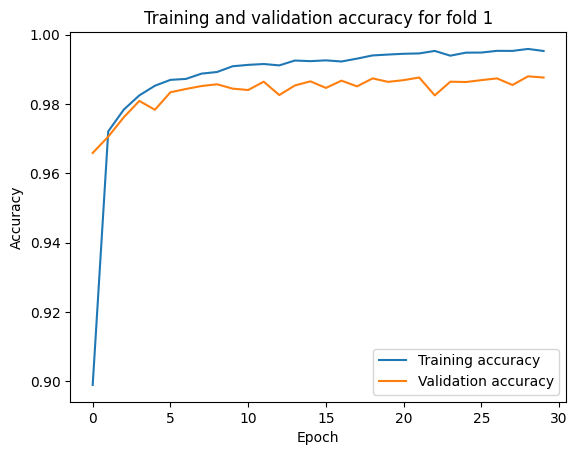

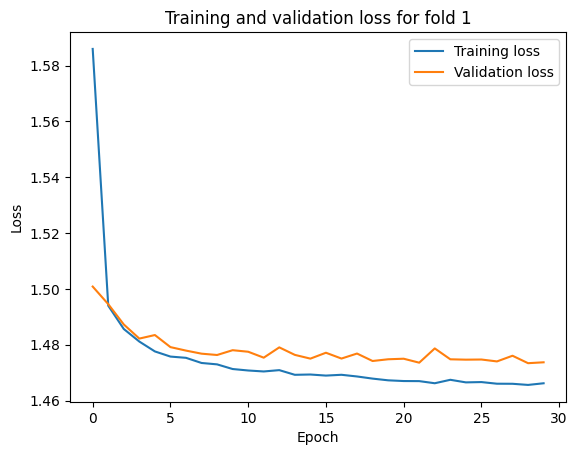

  3%|▎         | 1/30 [00:14<06:51, 14.21s/it]

Epoch 1/30 - Loss: 1.637 - Acc: 0.847
              Val_loss: 1.520 - Val_acc: 0.949


 37%|███▋      | 11/30 [02:35<04:29, 14.21s/it]

Epoch 11/30 - Loss: 1.474 - Acc: 0.988
              Val_loss: 1.481 - Val_acc: 0.981


 70%|███████   | 21/30 [05:03<02:16, 15.21s/it]

Epoch 21/30 - Loss: 1.469 - Acc: 0.993
              Val_loss: 1.478 - Val_acc: 0.984


func:'train'  took: 433.5239 sec
Training accuracy:  0.9949499999999997
Validation accuracy:  0.9867499999999981


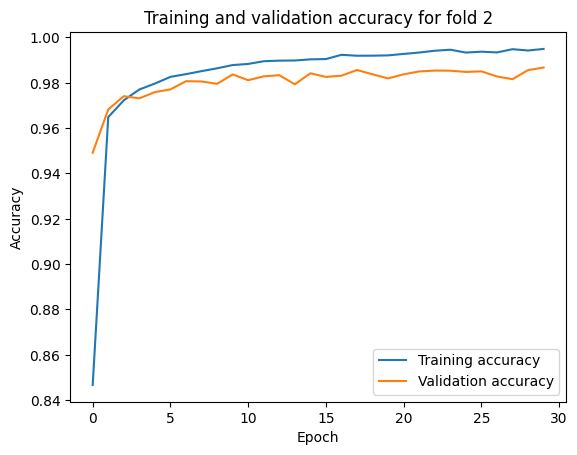

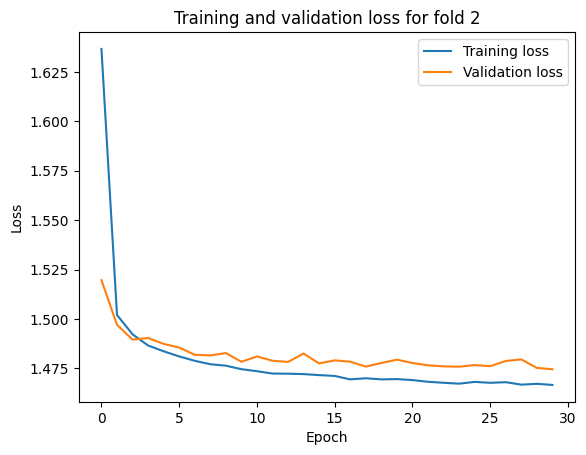

  3%|▎         | 1/30 [00:14<06:46, 14.00s/it]

Epoch 1/30 - Loss: 1.606 - Acc: 0.878
              Val_loss: 1.507 - Val_acc: 0.962


 37%|███▋      | 11/30 [02:37<04:30, 14.26s/it]

Epoch 11/30 - Loss: 1.471 - Acc: 0.991
              Val_loss: 1.478 - Val_acc: 0.984


 70%|███████   | 21/30 [04:59<02:09, 14.34s/it]

Epoch 21/30 - Loss: 1.467 - Acc: 0.995
              Val_loss: 1.476 - Val_acc: 0.986


func:'train'  took: 430.7598 sec
Training accuracy:  0.9958749999999987
Validation accuracy:  0.9871999999999983


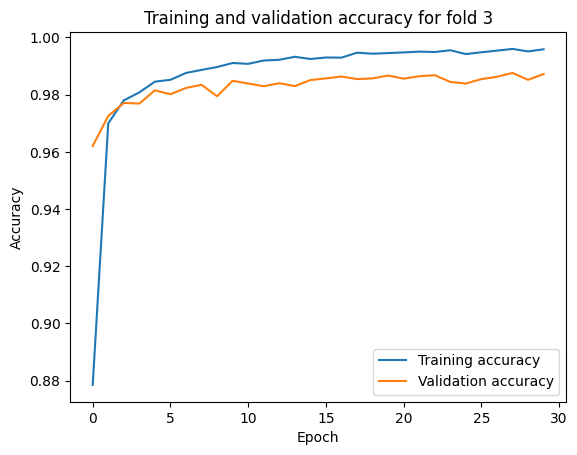

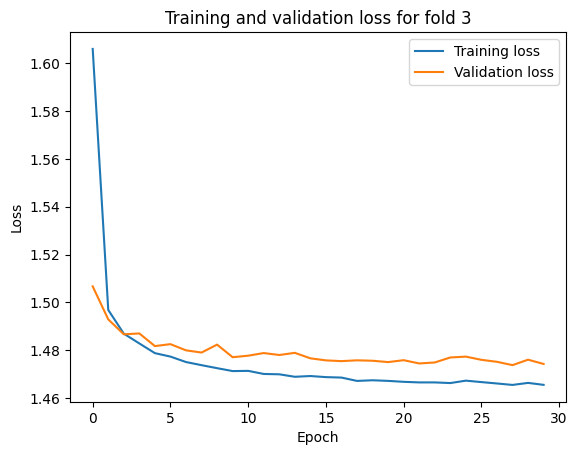

Summary: 
Training accuracy:  0.9953749999999989
Validation accuracy:  0.9871999999999982


In [ ]:
# The training and validation accuracy of the model
# The training and validation accuracy of the model
run_info_list = []
for i in range(3):
    model = ResNet_batch()
    trainer = Trainer(model, optimizer_type='adam', learning_rate=1e-3, batch_size=128, epoch=30, input_transform = lambda x:x)
    run_info = trainer.train(training_set[i], training_label[i], validation_set[i], validation_label[i])
    run_info_list.append(run_info)
    print("Training accuracy: ", run_info["accuracies"][-1])
    print("Validation accuracy: ", run_info["val_accuracies"][-1])

    # Plot the training and validation accuracy for fold 1 
    plt.plot(run_info["accuracies"], label="Training accuracy")
    plt.plot(run_info["val_accuracies"], label="Validation accuracy")
    plt.title("Training and validation accuracy for fold %d" % (i+1))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Plot the training and validation loss for fold 1
    plt.plot(run_info["losses"], label="Training loss")
    plt.plot(run_info["val_losses"], label="Validation loss")
    plt.title("Training and validation loss for fold %d" % (i+1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Summarize the training and validation accuracy of the model over the three folds 
print("Summary: ")
print("Training accuracy: ", np.mean([run_info["accuracies"][-1] for run_info in run_info_list]))
print("Validation accuracy: ", np.mean([run_info["val_accuracies"][-1] for run_info in run_info_list]))

I had expected that batch normalization would improve the accuracy and loss of the validation but as shown in the graphs above, it looks like including batch normalization not only decreased the accuracy of the validation set but also increased the loss. I believe either the implementation had some tweaks that needed to be made or maybe using skip connection ALONG with batch normalization would improve our results. 

### c) Run the model with and without skip connection at learning rate of 5e-3 for 10 epochs. Do you see faster training/and or better test accuracy with the skip connection?

In [10]:
#This model has batch normalization and skip connection
class ResNet_skip(nn.Module):
    def __init__(self):
        super(ResNet_skip, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1,6,kernel_size=3,padding=1), 
                                  nn.Conv2d(6,12,kernel_size=3,padding=1)]) 
        self.fc = nn.ModuleList([nn.Linear(300,300),nn.Linear(300,10)]) 
        self.pool1 = nn.MaxPool2d(kernel_size=2) 
        self.pool2 = nn.MaxPool2d(kernel_size=3) 
        self.activation = nn.ReLU()
        self.bn = [nn.BatchNorm2d(6), nn.BatchNorm2d(12)]

        
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.conv[0](x)
        x = self.bn[0](x)
        x = self.pool1(self.activation(x))
        x = self.conv[1](x)
        x = self.bn[1](x)
        x = self.pool2(self.activation(x))
        x = x.flatten(start_dim=1)
        residual = x.clone() 
        x = self.fc[0](x)
        x += residual
        x = self.activation(x)
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

 10%|█         | 1/10 [00:14<02:12, 14.70s/it]

Epoch 1/10 - Loss: 1.880 - Acc: 0.578
              Val_loss: 1.786 - Val_acc: 0.673


func:'train'  took: 152.9241 sec
Training accuracy:  0.9817000000000018
Validation accuracy:  0.979349999999998


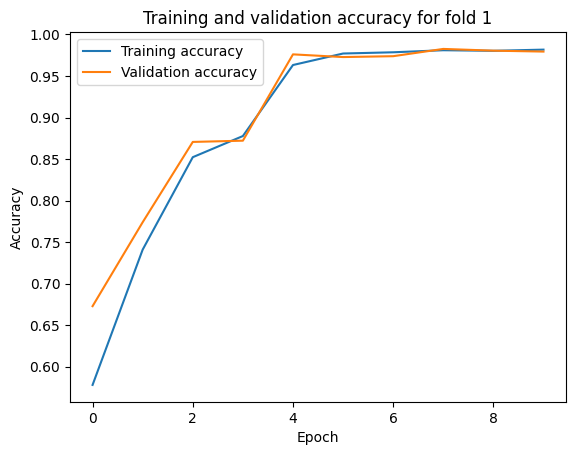

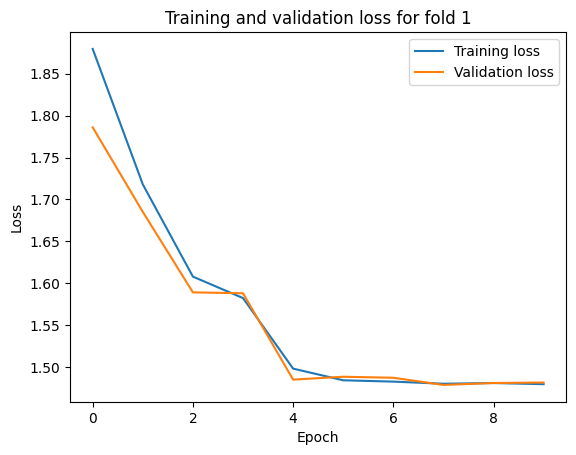

 10%|█         | 1/10 [00:14<02:13, 14.86s/it]

Epoch 1/10 - Loss: 1.732 - Acc: 0.729
              Val_loss: 1.593 - Val_acc: 0.867


func:'train'  took: 165.4920 sec
Training accuracy:  0.9774250000000011
Validation accuracy:  0.9735499999999983


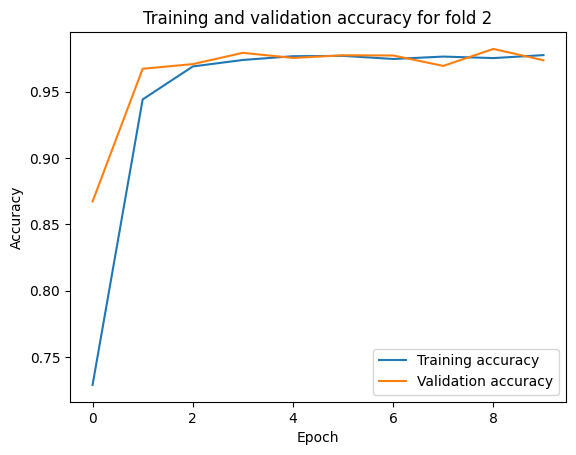

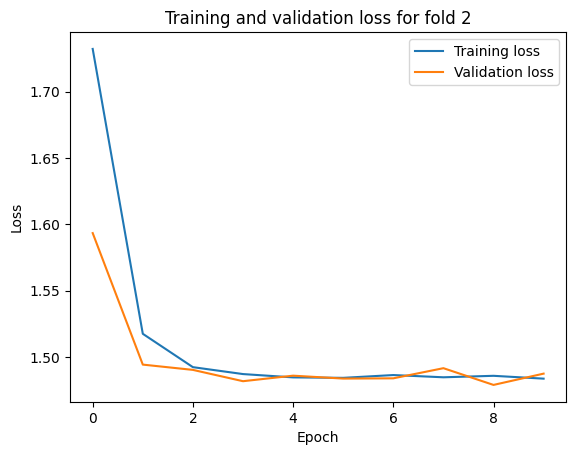

 10%|█         | 1/10 [00:14<02:14, 14.90s/it]

Epoch 1/10 - Loss: 1.809 - Acc: 0.651
              Val_loss: 1.589 - Val_acc: 0.872


func:'train'  took: 158.7462 sec
Training accuracy:  0.9778500000000017
Validation accuracy:  0.9771499999999977


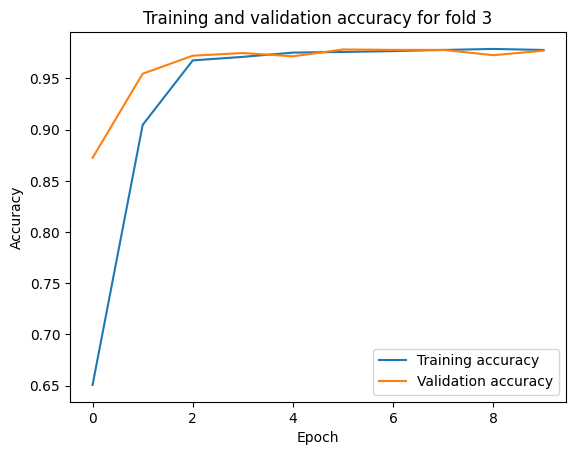

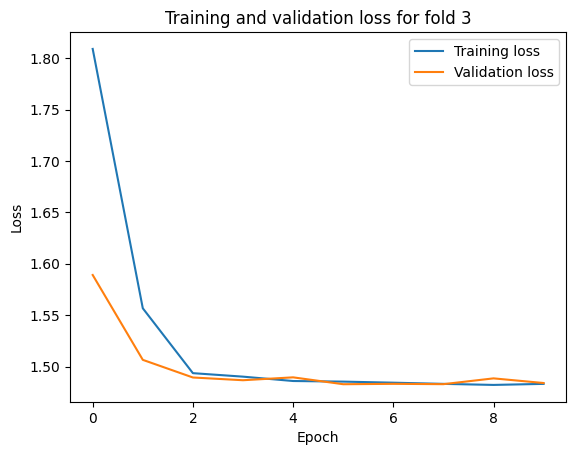

Summary: 
Training accuracy:  0.9789916666666683
Validation accuracy:  0.9766833333333315


In [11]:
# The training and validation accuracy of the model
# The training and validation accuracy of the model
run_info_list = []
for i in range(3):
    model = ResNet_skip()
    trainer = Trainer(model, optimizer_type='adam', learning_rate=5e-3, batch_size=128, epoch=10, input_transform = lambda x:x)
    run_info = trainer.train(training_set[i], training_label[i], validation_set[i], validation_label[i])
    run_info_list.append(run_info)
    print("Training accuracy: ", run_info["accuracies"][-1])
    print("Validation accuracy: ", run_info["val_accuracies"][-1])

    # Plot the training and validation accuracy for fold 1 
    plt.plot(run_info["accuracies"], label="Training accuracy")
    plt.plot(run_info["val_accuracies"], label="Validation accuracy")
    plt.title("Training and validation accuracy for fold %d" % (i+1))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Plot the training and validation loss for fold 1
    plt.plot(run_info["losses"], label="Training loss")
    plt.plot(run_info["val_losses"], label="Validation loss")
    plt.title("Training and validation loss for fold %d" % (i+1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Summarize the training and validation accuracy of the model over the three folds 
print("Summary: ")
print("Training accuracy: ", np.mean([run_info["accuracies"][-1] for run_info in run_info_list]))
print("Validation accuracy: ", np.mean([run_info["val_accuracies"][-1] for run_info in run_info_list]))

 10%|█         | 1/10 [00:15<02:16, 15.20s/it]

Epoch 1/10 - Loss: 1.801 - Acc: 0.659
              Val_loss: 1.677 - Val_acc: 0.784


func:'train'  took: 162.3384 sec
Training accuracy:  0.9749000000000019
Validation accuracy:  0.9627999999999987


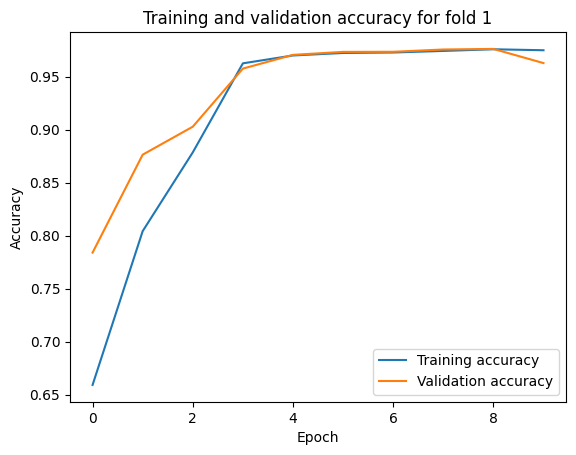

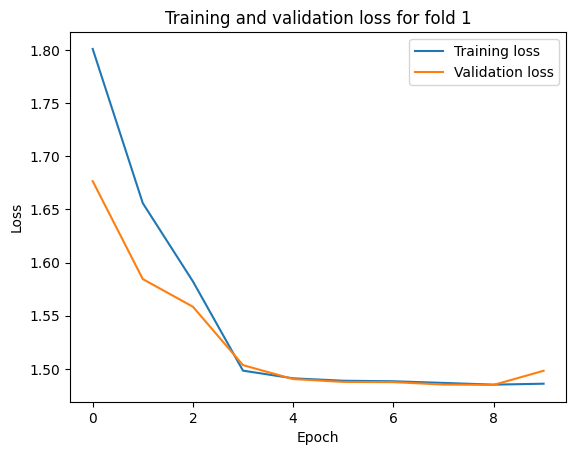

 10%|█         | 1/10 [00:15<02:18, 15.42s/it]

Epoch 1/10 - Loss: 1.633 - Acc: 0.830
              Val_loss: 1.580 - Val_acc: 0.881


func:'train'  took: 159.8047 sec
Training accuracy:  0.9762750000000018
Validation accuracy:  0.979149999999998


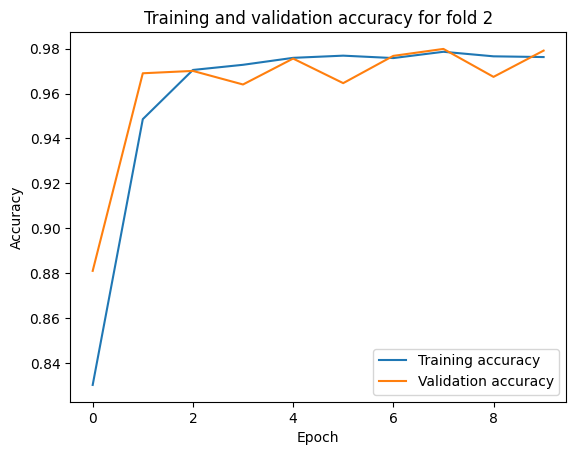

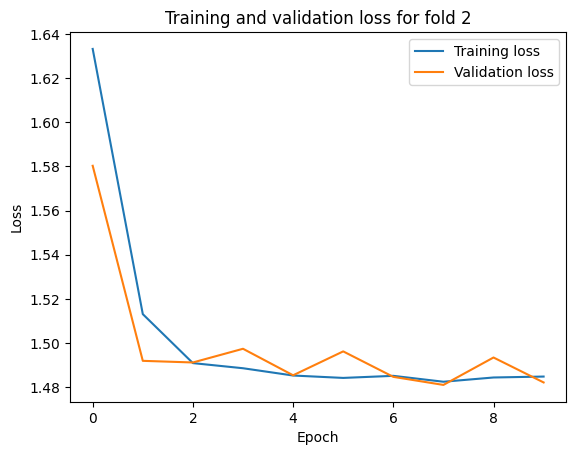

 10%|█         | 1/10 [00:14<02:08, 14.22s/it]

Epoch 1/10 - Loss: 1.748 - Acc: 0.713
              Val_loss: 1.593 - Val_acc: 0.868


func:'train'  took: 151.8636 sec
Training accuracy:  0.9803000000000013
Validation accuracy:  0.9791999999999978


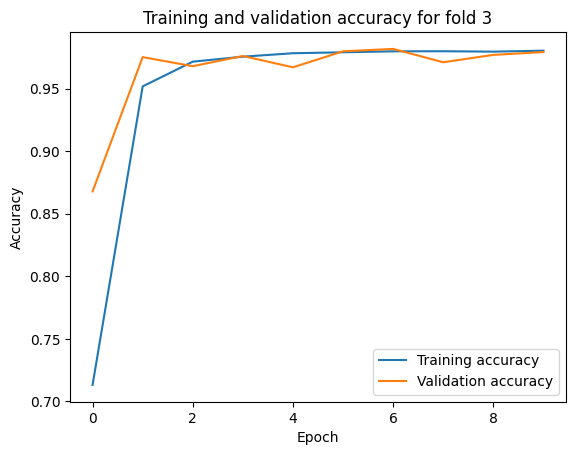

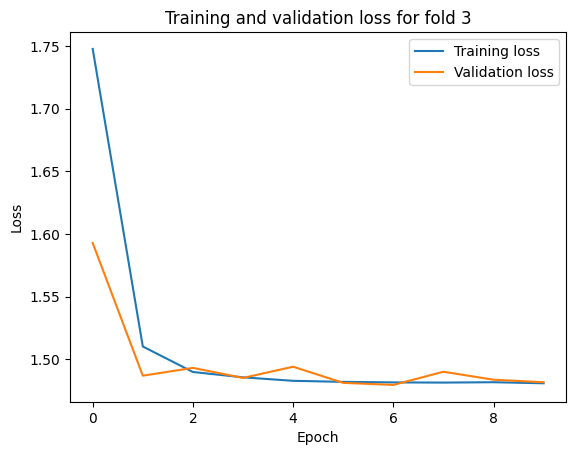

Summary: 
Training accuracy:  0.977158333333335
Validation accuracy:  0.9737166666666649


In [12]:
# The training and validation accuracy of the model
# The training and validation accuracy of the model
# This model is used for batch normalization with no skip but smaller number of epochs 
run_info_list = []
for i in range(3):
    model = ResNet_batch()
    trainer = Trainer(model, optimizer_type='adam', learning_rate=5e-3, batch_size=128, epoch=10, input_transform = lambda x:x)
    run_info = trainer.train(training_set[i], training_label[i], validation_set[i], validation_label[i])
    run_info_list.append(run_info)
    print("Training accuracy: ", run_info["accuracies"][-1])
    print("Validation accuracy: ", run_info["val_accuracies"][-1])

    # Plot the training and validation accuracy for fold 1 
    plt.plot(run_info["accuracies"], label="Training accuracy")
    plt.plot(run_info["val_accuracies"], label="Validation accuracy")
    plt.title("Training and validation accuracy for fold %d" % (i+1))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Plot the training and validation loss for fold 1
    plt.plot(run_info["losses"], label="Training loss")
    plt.plot(run_info["val_losses"], label="Validation loss")
    plt.title("Training and validation loss for fold %d" % (i+1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Summarize the training and validation accuracy of the model over the three folds 
print("Summary: ")
print("Training accuracy: ", np.mean([run_info["accuracies"][-1] for run_info in run_info_list]))
print("Validation accuracy: ", np.mean([run_info["val_accuracies"][-1] for run_info in run_info_list]))

As seen above, it seems that adding skip connection reduced the overal training and validation accuracy in both cases but using skip conection along with the reduced number of epochs and a higher learning rate made the algorithm much more faster. 